In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import torch as th

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [2]:
def modular_class(x, m):
    return x % m


def squared_modular_class(x, m):
    return (x**2) % m


def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


def get_q(x, P, rho):
    counts = th.bincount(x)
    _, order = th.sort(counts, descending=True)
    if P is None:
        P = len(counts)
    P = min(P, th.sum(counts!=0).item())
    idx = order[:P]
    q = (counts[idx] / counts[idx].sum())**rho
    return q, idx

Scaling with respect to d and T jointly

In [3]:
# number of input tokens
n = 100
# number of output classes
m = 5
# memory dimension
ds = np.logspace(1, 3, num=30, dtype=int)
dmax = np.max(ds)

# number of data
ts = np.logspace(1, 4, num=30, dtype=int)
tmax = np.max(ts)

# Zipf parameter
alpha = .5

In [4]:
# Population data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = modular_class(all_x, m)

In [5]:
P = None
rho = 0

nb_trials = 100

errors = th.zeros(nb_trials, len(ts), len(ds))
errors[:] = -1

for i_n in range(nb_trials):
    # Embeddings
    E = get_embeddings(n, dmax, norm=False)
    U = get_embeddings(m, dmax, norm=True)

    # Empirical data
    x = th.multinomial(proba, tmax, replacement=True)
    y = all_y[x]

    for i_t, t in enumerate(ts):
        q, idx = get_q(x[:t], P, rho)
        W = (E[idx].T * q) @ U[all_y[idx]]
        for i_d, d in enumerate(ds):
            scores = E[:, :d] @ W[:d,:d] @ U[:,:d].T
            preds = scores.argmax(dim=1)
            errors[i_n, i_t, i_d] = proba[preds != all_y].sum()

        # print(len(idx), end=',')
    print(i_n, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [6]:
errors_mean = errors.mean(dim=0)
errors_std = errors.std(dim=0)

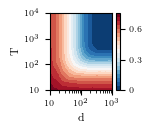

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

X, Y = np.meshgrid(ds, ts)
fig, ax = plt.subplots(figsize=(1, 1))
c = ax.contourf(X, Y, errors_mean.numpy(), levels=20, cmap='RdBu_r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10, 100, 1000])
ax.set_xticklabels(["10", r"$10^2$", r"$10^3$"], fontsize=6)
ax.set_yticks([10, 100, 1000, 10000])
ax.set_yticklabels(["10", r"$10^2$", r"$10^3$", r"$10^4$"], fontsize=6)
ax.set_xlabel('d', fontsize=8)
ax.set_ylabel('T', fontsize=8)
bar = fig.colorbar(c, ax=ax, ticks=[0, .3, .6, .9])
bar.set_ticklabels([r"$0$", r"$0.3$", r"$0.6$", r"$0.9$"], fontsize=6)
# fig.savefig('weight_storage_error.pdf', bbox_inches='tight')
fig.savefig('fill_storage_error.pdf', bbox_inches='tight')